# Estudio de diferentes modelos de QDA

Se procede a montar el Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se importan los módulos necesarios:

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf 

In [3]:
!pip3 install roc_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se carga el Dataset:

In [4]:
Datos = pd.read_excel('/content/drive/MyDrive/AB Proyecto/MI_cleandata_new.xlsx', sheet_name='Hoja1', index_col=0)
Datos.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 1648
Columns: 116 entries, AGE to zab_leg_06
dtypes: float64(5), int64(111)
memory usage: 1.5 MB


En la exploración inicial se ha determinado que las variables que presentan una relación con la variable ZSN són:

*   AGE
*   ZSN_A
*   OTEK_LANC
*   endocr_01
*   zab_leg_01
*   ALT_BLOOD
*   ROE

A continuación, se procede a crear modelos con las diferentes combinaciones de variables seleccionadas. Los hiperparámetros se escogeran usando la herramienta GridSearch de scikit-learn.

**Combinación 1:**
*   AGE
*   ALT_BLOOD

**Combinación 2:**
*   AGE
*   ALT_BLOOD
*   ZSN_A
*   ROE

**Combinación 3:**
*   AGE
*   ZSN_A
*   OTEK_LANC
*   SEX
*   ALT_BLOOD

**Combinación 4:**
*   AGE
*   ZSN_A
*   OTEK_LANC
*   endocr_01
*   zab_leg_01


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Crear numpy arrays con las diferentes variables escogidas como "features".
AGE = Datos['AGE'][:, np.newaxis]
OTEK_LANC	 = Datos['OTEK_LANC'][:, np.newaxis]
SEX = Datos['SEX'][:, np.newaxis]
ZSN_A = Datos['ZSN_A'][:, np.newaxis]
ALT_BLOOD = Datos['ALT_BLOOD'][:, np.newaxis]
ROE = Datos['ROE'][:, np.newaxis]
endocr_01 = Datos['endocr_01'][:, np.newaxis]
zab_leg_01 = Datos['zab_leg_01'][:, np.newaxis]

# Imprimir forma de los arrays para verificar que se han creado correctamente.
print(AGE.shape)
print(OTEK_LANC.shape)
print(SEX.shape)
print(ZSN_A.shape)
print(ALT_BLOOD.shape)
print(endocr_01.shape)
print(ROE.shape)
print(zab_leg_01.shape)

(1649, 1)
(1649, 1)
(1649, 1)
(1649, 1)
(1649, 1)
(1649, 1)
(1649, 1)
(1649, 1)


In [6]:
# Crear numpy arrays con los "labels" de variable a predecir.
ZSN = Datos['ZSN']

# Imprimir forma del array para verificar que se ha creado correctamente.
print(ZSN.shape)

(1649,)


A continuación, se crearan 6 arrays de features, creados a partir de las 6 combinaciones posibles a generar a partir de la unión de las 3 variables.

In [7]:
from numpy.core.multiarray import concatenate

# Crear los 6 arrays de features a partir de las combinaciones de las 6 variables:

# Combinación 1:
X_1 = np.concatenate((AGE, ALT_BLOOD), axis=1)

# Combinación 2:
X_2 = np.concatenate((AGE, ALT_BLOOD, ZSN_A, ROE), axis=1)

# Combinación 3:
X_3 = np.concatenate((AGE, ZSN_A, OTEK_LANC, SEX, ALT_BLOOD), axis=1)

# Combinación 4:
X_4 = np.concatenate((AGE, ZSN_A, OTEK_LANC, endocr_01, zab_leg_01), axis=1)

# Imprimir forma de los arrays para verificar que se han creado correctamente.
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)
print(X_4.shape)

(1649, 2)
(1649, 4)
(1649, 5)
(1649, 5)


In [8]:
# Definir el array de labels de la variable a predecir.
y = ZSN

A continuación, se procede a crear un modelo para cada una de las 4 combinaciones. Los pasos a seguir són:

1.- Dividir los datos.

2.- Escalamiento de datos.

3.- Efectuar un GridSearch para encontrar los mejores hiperparámetros especificos para el modelo en cuestión.

4.- Entrenamiento del modelo.

5.- Análisis de los resultados obtenidos: Classification report, matrix de confusión y curva ROC.

6.- Validación cruzada con K-fold.


## Modelo 1: Combinación 1

### Dividir los datos

In [9]:
from sklearn.model_selection import train_test_split

X = X_1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Escalamiento de datos

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

### Entrenamiento del modelo

In [11]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Creación del modelo QDA:
model_QDA = QuadraticDiscriminantAnalysis()

# Entrenamiento:
model_QDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

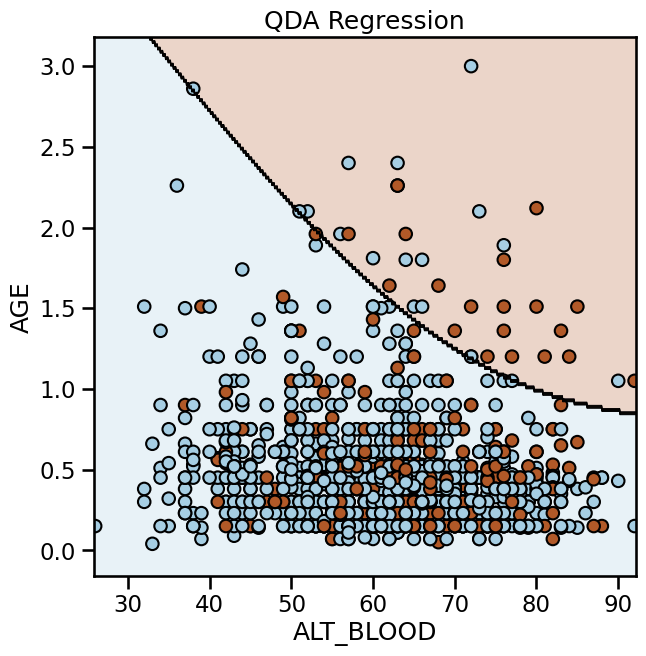

In [12]:
def plot_decision_boundary(clf, X, Y, cmap='Paired'):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k', label=Y);
  
sns.set_context("talk")
plot_decision_boundary(model_QDA ,X_train,y_train)
plt.title("QDA Regression");
plt.xlabel("ALT_BLOOD")
plt.ylabel("AGE")
plt.show()

### Evaluación del modelo

#### Evaluación de los resultados del entrenamiento

In [13]:
from sklearn.metrics import accuracy_score 

# Accuracy y error de entrenamiento.
y_train_pred = model_QDA.predict(X_train_scal)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_err = 1-train_accuracy

print("Accuracy: {} \nTrainig error: {}".format(train_accuracy, train_err))

Accuracy: 0.7536012130401819 
Trainig error: 0.2463987869598181


In [14]:
# Función para visualizar la matrix de confusión
def plot_cm(Y, y_pred,clf):
    cm = confusion_matrix(Y, y_pred)
    cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Predicted'
    ax=sns.heatmap(cm_df, # Visualizando la matriz de confusion
             annot=True, fmt='2d', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':20})

Classification report
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1012
           1       0.15      0.01      0.02       307

    accuracy                           0.75      1319
   macro avg       0.46      0.50      0.44      1319
weighted avg       0.62      0.75      0.66      1319

 
Matriz de confusión


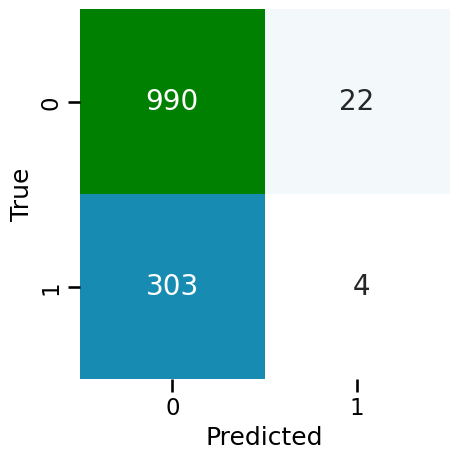

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report.
print('Classification report')
print(classification_report(y_train, y_train_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_train, y_train_pred, clf=model_QDA)

In [16]:
# Funcion para calcular y visualizar la curva ROC.
def curveROC(X,y,model1_QDA):
    
    from sklearn.metrics import roc_curve, auc 
    
    y_prob = model_QDA.predict_proba(X)
    # calcula fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y, y_prob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Calcula el mejor threshold
    optimal_idx = np.argmax(tpr * (1-fpr))
    optimal_threshold = thresholds[optimal_idx]

    # Grafica ROC curve
    sns.set(font_scale=1)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr[optimal_idx],tpr[optimal_idx],'o',label='Optimal threshold = %0.2f' % optimal_threshold)
    plt.plot([0, 1], [0, 1], 'k--')# curva de predicciones aleatorias  
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

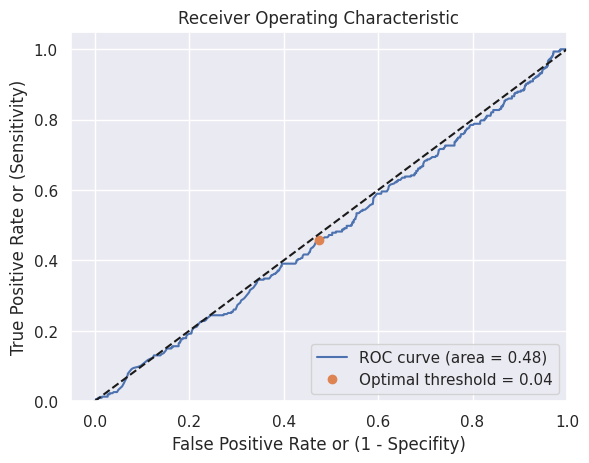

In [17]:
# Curva ROC.
curveROC(X_train_scal, y_train, model_QDA)

####Evaluación de los resultados del test

In [18]:
# Accuracy y error de test.
y_test_pred = model_QDA.predict(X_test_scal)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_err = 1-test_accuracy

print("Accuracy: {} \nTest error: {}".format(test_accuracy, test_err))

Accuracy: 0.7575757575757576 
Test error: 0.24242424242424243


Classification report
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       253
           1       0.29      0.03      0.05        77

    accuracy                           0.76       330
   macro avg       0.53      0.50      0.45       330
weighted avg       0.66      0.76      0.67       330

 
Matriz de confusión


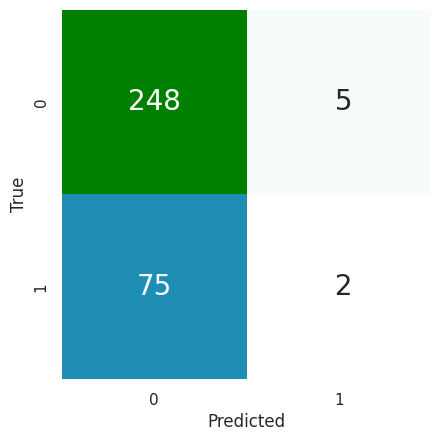

In [19]:
# Classification report.
print('Classification report')
print(classification_report(y_test, y_test_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_test, y_test_pred, clf=model_QDA)

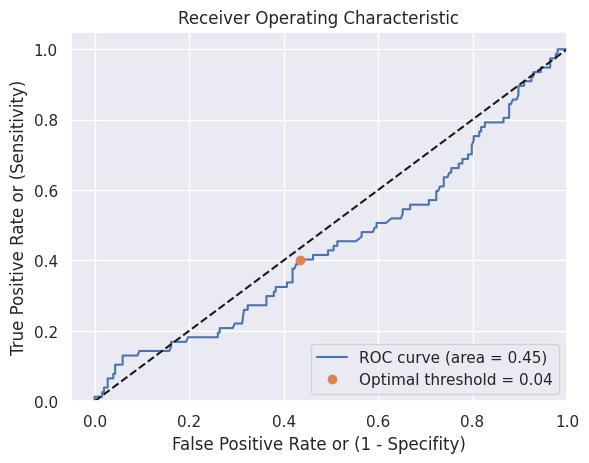

In [20]:
# Curva ROC.
curveROC(X_test_scal, y_test, model_QDA)

### Validación cruzada

In [21]:
# Funcion para calcular y visualizar la matriz de confusion 
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    from sklearn.metrics import confusion_matrix
    CM = confusion_matrix(ytrue,ypred)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
    if clases == None:
        clases = list(set(ytrue))    # corregido el bug, las clases deben ser con la verdad!
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':16}, ax=ax )
    
    #plt.show()

Iteración 1
Precision promedio =  0.42857142857142855
Accuracy promedio =  0.7636363636363637
Sensibility promedio =  0.03896103896103896
Specificity promedio =  0.9841897233201581
Iteración 2
Precision promedio =  0.521978021978022
Accuracy promedio =  0.7696969696969698
Sensibility promedio =  0.07142857142857142
Specificity promedio =  0.9822134387351779
Iteración 3
Precision promedio =  0.6336996336996337
Accuracy promedio =  0.7737373737373737
Sensibility promedio =  0.07359307359307359
Specificity promedio =  0.9868247694334652
Iteración 4
Precision promedio =  0.5752747252747252
Accuracy promedio =  0.7704545454545455
Sensibility promedio =  0.06818181818181818
Specificity promedio =  0.9841897233201582
Iteración 5
Precision promedio =  0.49098901098901093
Accuracy promedio =  0.7646919038408401
Sensibility promedio =  0.05980861244019138
Specificity promedio =  0.9786561264822135


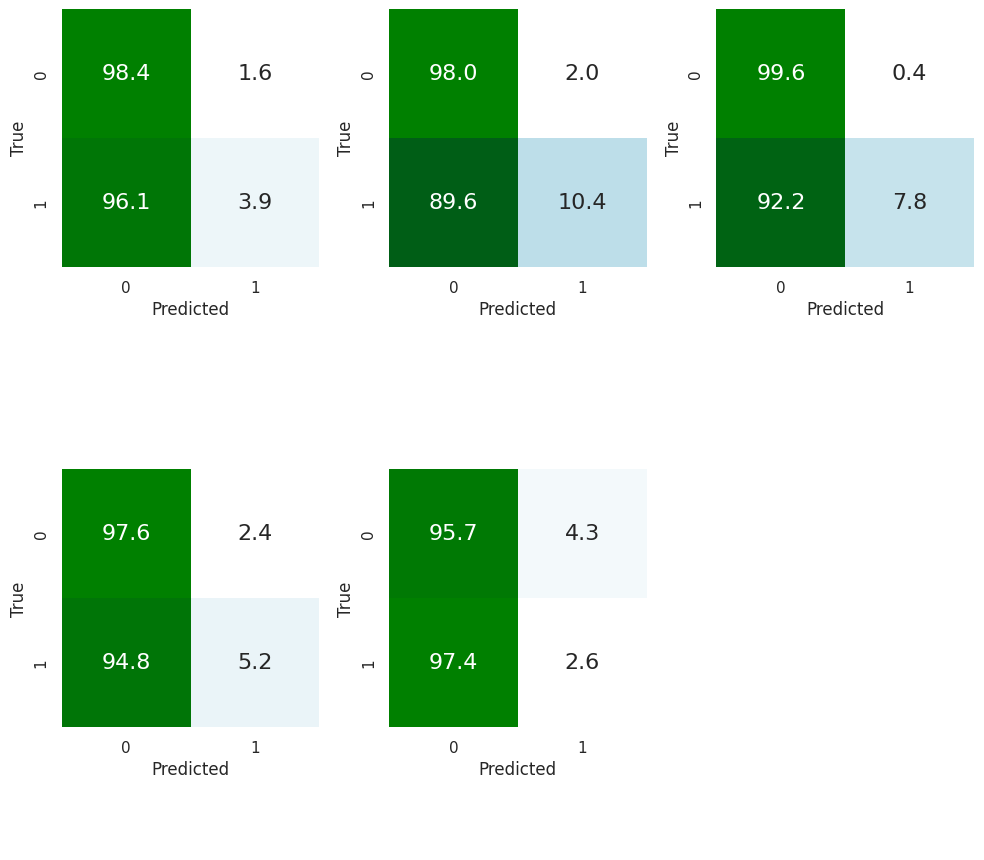

In [22]:
from sklearn.model_selection import StratifiedKFold
import roc_utils as ru
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.metrics import precision_score, accuracy_score, recall_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # instancia al objeto cross validator con 5 folds

# Definición de las listas para almacenar las medidas de rendimiento
pre = []
acc = []
sen = []
spe = []

iter = 0
rocs = []

fig, ax = plt.subplots(2,3,figsize = (10,10))
k = 0
    
for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train_scaled, y_train) 
    y_pred_test = model.predict(X_test_scaled)
    
    pre.append(precision_score(y_test,y_pred_test)) 
    acc.append(accuracy_score(y_test,y_pred_test))
    sen.append(recall_score(y_test,y_pred_test))
    spe.append(recall_score(y_test,y_pred_test, pos_label=0))
    
    iter = iter + 1
    print('Iteración', iter)
    print("Precision promedio = ", np.mean(pre))
    print("Accuracy promedio = ", np.mean(acc))
    print("Sensibility promedio = ", np.mean(sen))
    print("Specificity promedio = ", np.mean(spe))
    
    # Matriz de confusion especificando los ejes (aplanados)
    plotCM(y_test,y_pred_test,normalize=True, ax = ax.flatten()[k])
    k += 1
    
    ax[1,2].axis('off')

    # set the spacing between subplots
    fig.tight_layout()

    plt.show

    #Las curvas ROC de cada iteración    
    y_prob = model.predict_proba(X_test)

    roc = ru.compute_roc(X=y_prob[:,1], y=y_test, pos_label=True)
    rocs.append(roc)
  

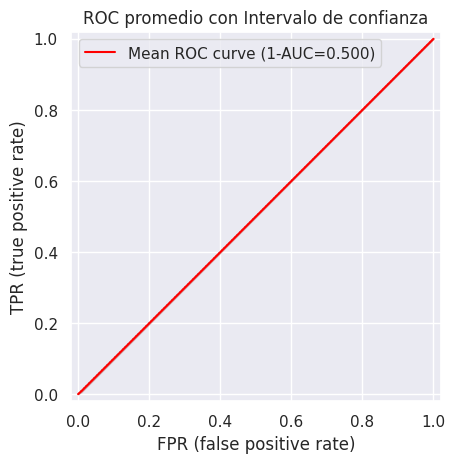

In [23]:
# El promedio, el intervalo de tolerancia (TI) y el intervalo de confianza (IC) de las curvas ROC de cada iteración
ru.plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("ROC promedio con Intervalo de confianza");

### Discusión de resultados

El modelo que emplea las variables de AGE y ALT_BLOOD, primeramente se valora que presenta un valor de "Accuracy" considerable, concretamente de aproximadamente el 75% tanto para el entrenamiento, para el testeo y para las diferentes iteraciones de la validación cruzada. 

Si se realiza el análisis del "Classification Report", se advierte cómo los resultados no són tan favorables como en un principio se observaba, en este apreciamos como tanto para el entrenamiento como el testeo tenemos valores de "precision" menores a 0.3, valores de "recall" menores a 0.05 y "F-Score" menores a 0.05, valores ínfimos de los cuales se puede concluir que el modelo de variables AGE y ALT_BLOOD, empleando el clasificador QDA, no predice bien la salida ZSN. Esto se confirma mediante las curvas ROC (con AUC menores a 0.5) y, aunque en la validación cruzada se muestran mejores valores de "precision" (oscilan el 50%), la sensibilidad (recall) sigue siendo ínfima.

## Modelo 2: Combinación 2

### Dividir los datos

In [24]:
X = X_2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Escalamiento de datos

In [25]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

### Entrenamiento del modelo

In [26]:
# Creación del modelo QDA.
model_QDA = QuadraticDiscriminantAnalysis()

# Entrenamiento.
model_QDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

### Evaluación del modelo

####Evaluación de los resultados del entrenamiento

In [27]:
# Accuracy y error de entrenamiento.
y_train_pred = model_QDA.predict(X_train_scal)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_err = 1-train_accuracy

print("Accuracy: {} \nTrainig error: {}".format(train_accuracy, train_err))

Accuracy: 0.7429871114480667 
Trainig error: 0.25701288855193327


Classification report
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1012
           1       0.34      0.11      0.16       307

    accuracy                           0.74      1319
   macro avg       0.56      0.52      0.51      1319
weighted avg       0.67      0.74      0.69      1319

 
Matriz de confusión


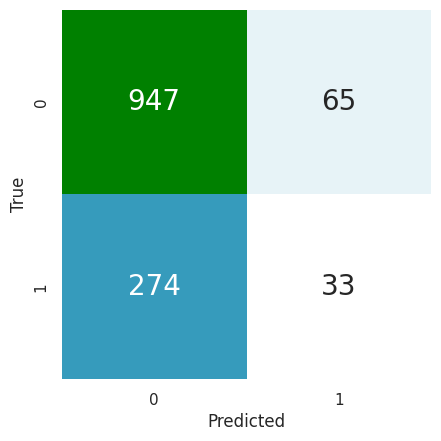

In [28]:
# Classification report.
print('Classification report')
print(classification_report(y_train, y_train_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_train, y_train_pred, clf=model_QDA)

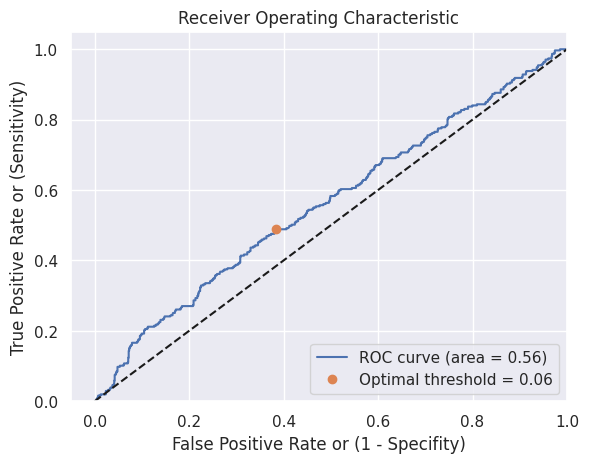

In [29]:
# Curva ROC.
curveROC(X_train_scal, y_train, model_QDA)

####Evaluación de los resultados del test

In [30]:
# Accuracy y error de test.
y_test_pred = model_QDA.predict(X_test_scal)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_err = 1-test_accuracy

print("Accuracy: {} \nTest error: {}".format(test_accuracy, test_err))

Accuracy: 0.7363636363636363 
Test error: 0.26363636363636367


Classification report
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       253
           1       0.29      0.09      0.14        77

    accuracy                           0.74       330
   macro avg       0.53      0.51      0.49       330
weighted avg       0.66      0.74      0.68       330

 
Matriz de confusión


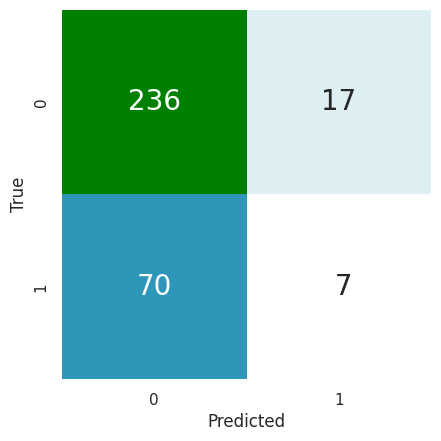

In [31]:
# Classification report.
print('Classification report')
print(classification_report(y_test, y_test_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_test, y_test_pred, clf=model_QDA)

In [ ]:
# Curva ROC.
curveROC(X_test_scal, y_test, model)

### Validación cruzada

Iteración 1
Precision promedio =  0.45
Accuracy promedio =  0.7606060606060606
Sensibility promedio =  0.11688311688311688
Specificity promedio =  0.9565217391304348
Iteración 2
Precision promedio =  0.4392857142857143
Accuracy promedio =  0.759090909090909
Sensibility promedio =  0.11688311688311688
Specificity promedio =  0.9545454545454546
Iteración 3
Precision promedio =  0.4105042016806723
Accuracy promedio =  0.7565656565656566
Sensibility promedio =  0.10389610389610389
Specificity promedio =  0.9552042160737813
Iteración 4
Precision promedio =  0.36050973020787264
Accuracy promedio =  0.7507575757575757
Sensibility promedio =  0.09090909090909091
Specificity promedio =  0.9515810276679841
Iteración 5
Precision promedio =  0.33126492702344096
Accuracy promedio =  0.744679008934328
Sensibility promedio =  0.08851674641148326
Specificity promedio =  0.9438735177865611


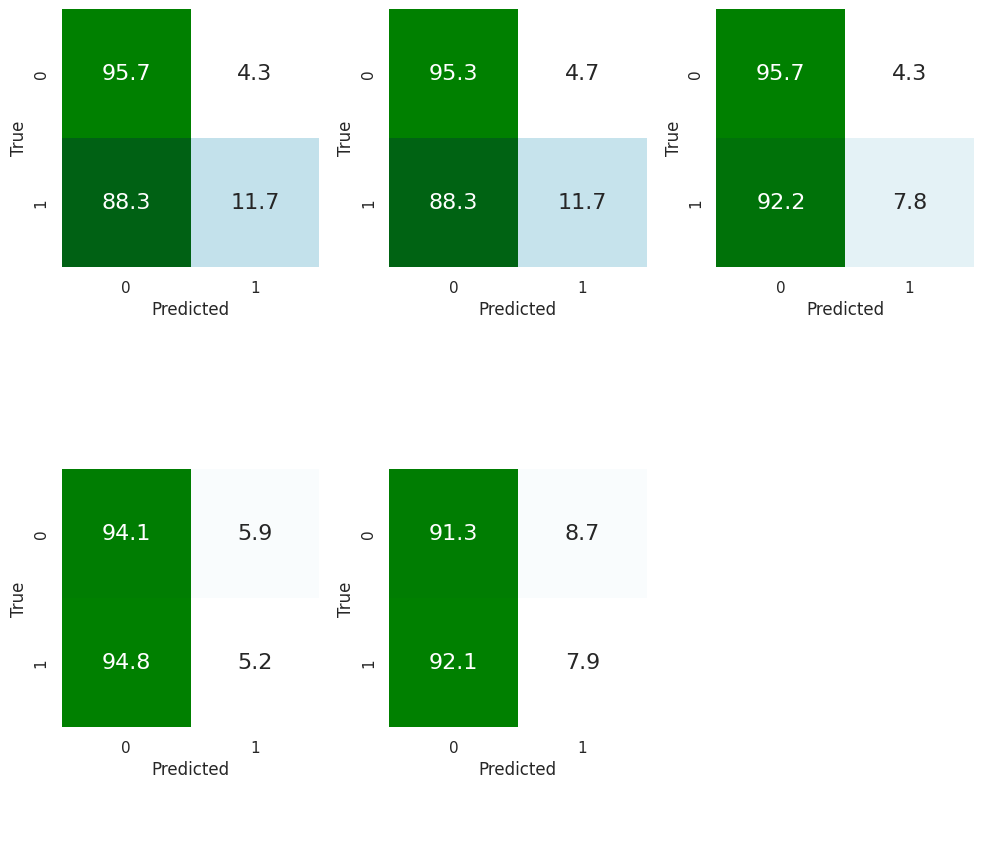

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # instancia al objeto cross validator con 5 folds

# Definición de las listas para almacenar las medidas de rendimiento
pre = []
acc = []
sen = []
spe = []

iter = 0
rocs = []

fig, ax = plt.subplots(2,3,figsize = (10,10))
k = 0
    
for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train_scaled, y_train) 
    y_pred_test = model.predict(X_test_scaled)
    
    pre.append(precision_score(y_test,y_pred_test)) 
    acc.append(accuracy_score(y_test,y_pred_test))
    sen.append(recall_score(y_test,y_pred_test))
    spe.append(recall_score(y_test,y_pred_test, pos_label=0))
    
    iter = iter + 1
    print('Iteración', iter)
    print("Precision promedio = ", np.mean(pre))
    print("Accuracy promedio = ", np.mean(acc))
    print("Sensibility promedio = ", np.mean(sen))
    print("Specificity promedio = ", np.mean(spe))
    
    # Matriz de confusion especificando los ejes (aplanados)
    plotCM(y_test,y_pred_test,normalize=True, ax = ax.flatten()[k])
    k += 1
    
    ax[1,2].axis('off')
    
    # set the spacing between subplots
    fig.tight_layout()
    
    plt.show
  
    #Las curvas ROC de cada iteración    
    y_prob = model.predict_proba(X_test)

    roc = ru.compute_roc(X=y_prob[:,1], y=y_test, pos_label=True)
    rocs.append(roc)

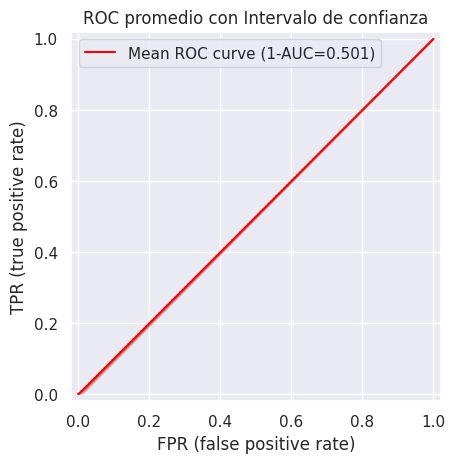

In [ ]:
# El promedio, el intervalo de tolerancia (TI) y el intervalo de confianza (IC) de las curvas ROC de cada iteración
ru.plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("ROC promedio con Intervalo de confianza");

### Discusión de resultados

Para el modelo propio de la combinación 2, se observa que presenta un valor de "Accuracy" semejante al de la combinación 1, de aproximadamente el 75% tanto para el entrenamiento, para el testeo y para las diferentes iteraciones de la validación cruzada. 

Si se realiza el análisis del "Classification Report", se aprecia como los resultados vuelven a no ser óptimos, pero, son mejores que en el modelo anterior, teniendo una precisión entre el 30% y 40% para entrenamiento, testeo y validación cruzada, por otro lado, el "recall" también aumenta ligeramente respecto al modelo anterior, oscilando ahora en el 10%. Por lo tanto, habiendo aumentado estos dos valores, la "F1-Score" también lo hará, aproximandose ahora al 15%. 

Esta leve mejoria respecto a la combinación 1 se aprecia de igual manera en el análisis de la curva ROC, donde el Área Bajo la Curva (AUC) ha aumentado al 50%.

Por lo tanto, esta modelo que emplea las variables AGE, ALT_BLOOD, ZSN_A y ROE sigue sin ser útil empleando el clasificador QDA, pero obtiene mejores resultados que la combinación 1.

## Modelo 3: Combinación 3

### Dividir los datos

In [ ]:
X = X_3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Escalamiento de datos

In [ ]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

### Entrenamiento del modelo

In [ ]:
# Creación del modelo QDA:
model_QDA = QuadraticDiscriminantAnalysis()

# Entrenamiento:
model_QDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

### Evaluación del modelo

####Evaluación de los resultados del entrenamiento

In [ ]:
# Accuracy y error de entrenamiento.
y_train_pred = model_QDA.predict(X_train_scal)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_err = 1-train_accuracy

print("Accuracy: {} \nTrainig error: {}".format(train_accuracy, train_err))

Accuracy: 0.6641394996209249 
Trainig error: 0.3358605003790751


Classification report
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1012
           1       0.33      0.44      0.38       307

    accuracy                           0.66      1319
   macro avg       0.57      0.58      0.57      1319
weighted avg       0.70      0.66      0.68      1319

 
Matriz de confusión


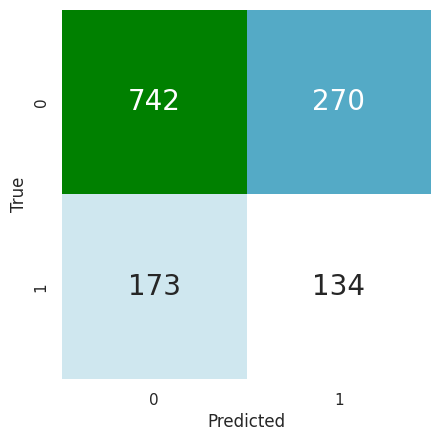

In [ ]:
# Classification report.
print('Classification report')
print(classification_report(y_train, y_train_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_train, y_train_pred, clf=model_QDA)

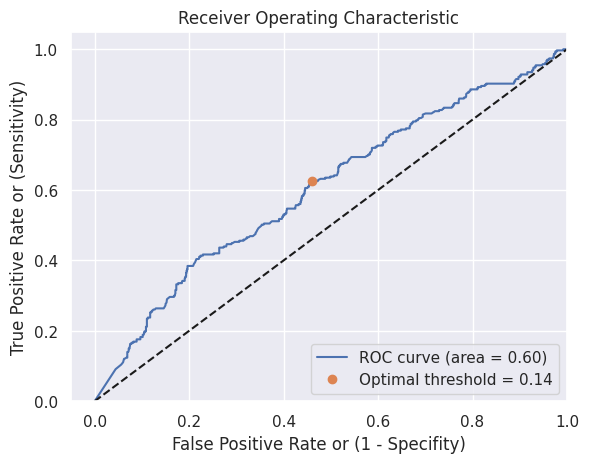

In [ ]:
# Curva ROC.
curveROC(X_train_scal, y_train, model_QDA)

####Evaluación de los resultados del test

In [ ]:
# Accuracy y error de test.
y_test_pred = model_QDA.predict(X_test_scal)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_err = 1-test_accuracy

print("Accuracy: {} \nTest error: {}".format(test_accuracy, test_err))

Accuracy: 0.6515151515151515 
Test error: 0.3484848484848485


Classification report
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       253
           1       0.31      0.39      0.34        77

    accuracy                           0.65       330
   macro avg       0.55      0.56      0.55       330
weighted avg       0.68      0.65      0.66       330

 
Matriz de confusión


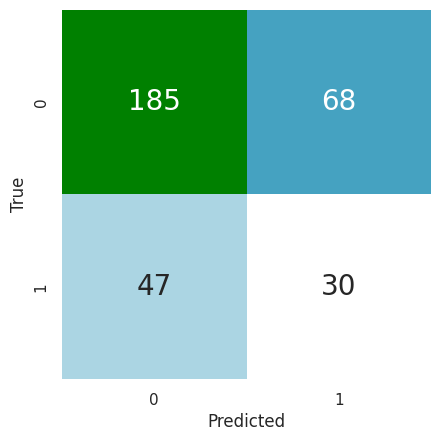

In [ ]:
# Classification report.
print('Classification report')
print(classification_report(y_test, y_test_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_test, y_test_pred, clf=model_QDA)

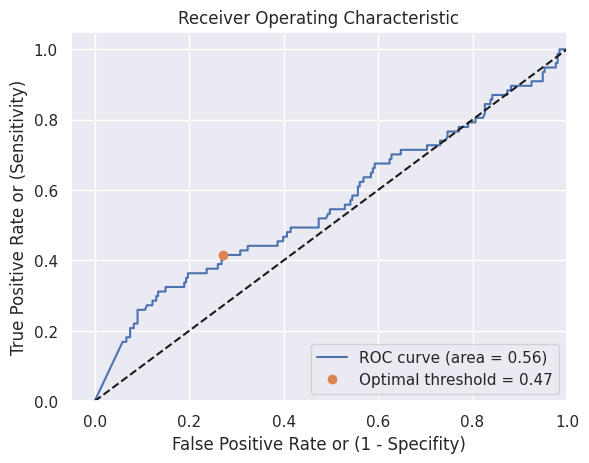

In [ ]:
# Curva ROC.
curveROC(X_test_scal, y_test, model)

### Validación cruzada

Iteración 1
Precision promedio =  0.5
Accuracy promedio =  0.7666666666666667
Sensibility promedio =  0.2727272727272727
Specificity promedio =  0.9169960474308301
Iteración 2
Precision promedio =  0.45
Accuracy promedio =  0.7515151515151515
Sensibility promedio =  0.2662337662337662
Specificity promedio =  0.8992094861660079
Iteración 3
Precision promedio =  0.42698412698412697
Accuracy promedio =  0.7464646464646464
Sensibility promedio =  0.24675324675324672
Specificity promedio =  0.8985507246376812
Iteración 4
Precision promedio =  0.3916666666666666
Accuracy promedio =  0.7378787878787878
Sensibility promedio =  0.22402597402597402
Specificity promedio =  0.8942687747035574
Iteración 5
Precision promedio =  0.37999999999999995
Accuracy promedio =  0.7331601731601731
Sensibility promedio =  0.2265892002734108
Specificity promedio =  0.8869565217391304


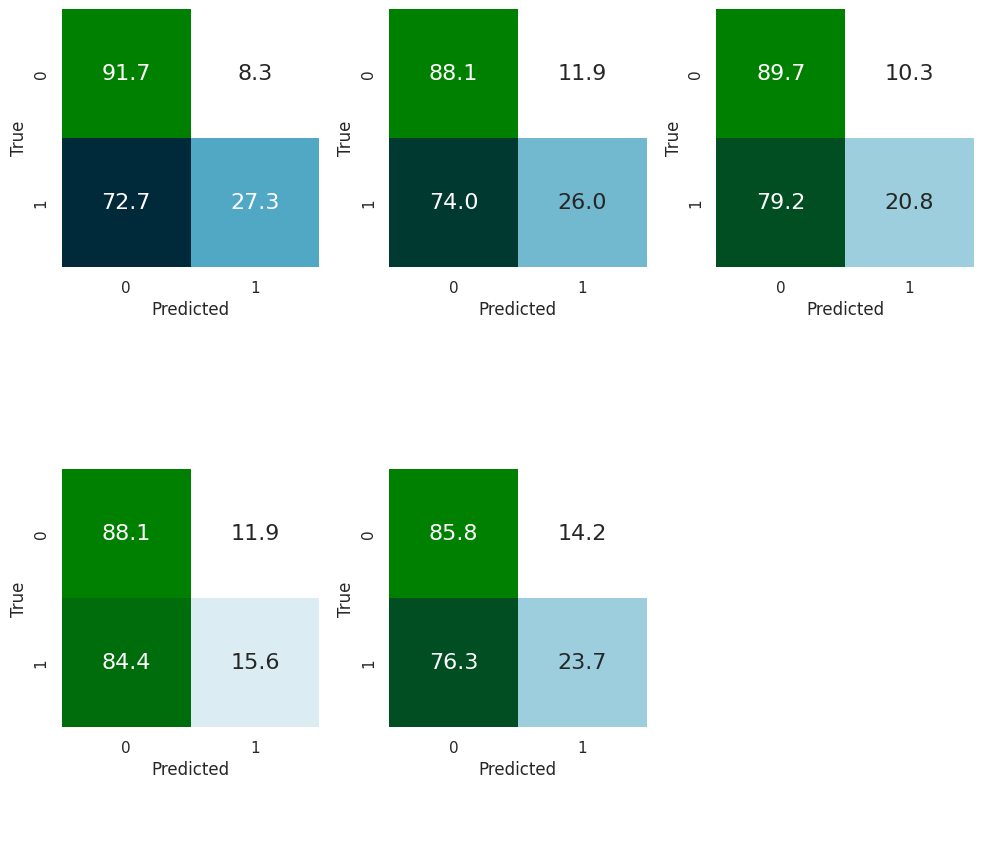

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # instancia al objeto cross validator con 5 folds

# Definición de las listas para almacenar las medidas de rendimiento
pre = []
acc = []
sen = []
spe = []

iter = 0
rocs = []

fig, ax = plt.subplots(2,3,figsize = (10,10))
k = 0
    
for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train_scaled, y_train) 
    y_pred_test = model.predict(X_test_scaled)
    
    pre.append(precision_score(y_test,y_pred_test)) 
    acc.append(accuracy_score(y_test,y_pred_test))
    sen.append(recall_score(y_test,y_pred_test))
    spe.append(recall_score(y_test,y_pred_test, pos_label=0))
    
    iter = iter + 1
    print('Iteración', iter)
    print("Precision promedio = ", np.mean(pre))
    print("Accuracy promedio = ", np.mean(acc))
    print("Sensibility promedio = ", np.mean(sen))
    print("Specificity promedio = ", np.mean(spe))
    
    # Matriz de confusion especificando los ejes (aplanados)
    plotCM(y_test,y_pred_test,normalize=True, ax = ax.flatten()[k])
    k += 1
    
    ax[1,2].axis('off')
    
    # set the spacing between subplots
    fig.tight_layout()
    
    plt.show
  
    #Las curvas ROC de cada iteración    
    y_prob = model.predict_proba(X_test)

    roc = ru.compute_roc(X=y_prob[:,1], y=y_test, pos_label=True)
    rocs.append(roc)

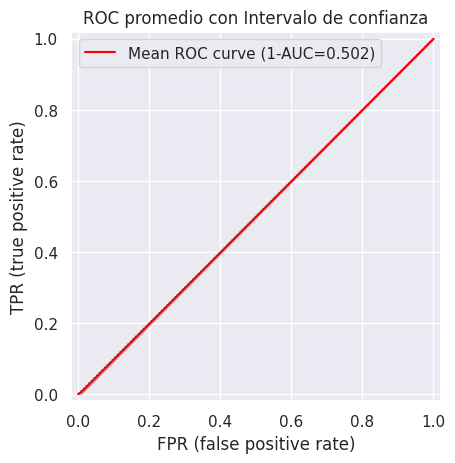

In [ ]:
# El promedio, el intervalo de tolerancia (TI) y el intervalo de confianza (IC) de las curvas ROC de cada iteración
ru.plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("ROC promedio con Intervalo de confianza");

### Discusión de resultados

En la combinación 3, formada por AGE, ZSN_A, OTEK_LANC, SEX y ALT_BLOOD, a priori, puede parecer que es peor que las 2 anteriores, pues el "accuracy" obtenido en el entrenamiento y testeo disminuye hacia un valor aproximado del 65%, mientras que en la validación cruzada oscila el 75%.

En cuanto al "Classification Report", este modelo consigue, tanto en entrenamiento como testeo, precisiones aproximadas al 30% y sensibilidades del 40%, mientras que en la validación cruzada la sensibilidad cae al 25% mientras que la precisión es ligeramente superior al 40%. Contando con una "F1-Score" de aproximadamente el 35%, se puede decir que el modelo sigue sin ser útil pero supera a los dos anteriores.

La misma conclusión se puede obtener mediante la observación de la curva ROC, que expone un area entre el 58% y el 60%, valores considerablemente mejores a las dos combinaciones anteriores.


## Modelo 4: Combinación 4

### Dividir los datos

In [ ]:
X = X_4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Escalamiento de datos

In [ ]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

### Entrenamiento del modelo

In [ ]:
# Creación del modelo QDA:
model_QDA = QuadraticDiscriminantAnalysis()

# Entrenamiento:
model_QDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

### Evaluación del modelo

####Evaluación de los resultados del entrenamiento

In [ ]:
# Accuracy y error de entrenamiento.
y_train_pred = model_QDA.predict(X_train_scal)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_err = 1-train_accuracy

print("Accuracy: {} \nTrainig error: {}".format(train_accuracy, train_err))

Accuracy: 0.6785443517816527 
Trainig error: 0.32145564821834727


Classification report
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1012
           1       0.36      0.47      0.40       307

    accuracy                           0.68      1319
   macro avg       0.59      0.61      0.59      1319
weighted avg       0.71      0.68      0.69      1319

 
Matriz de confusión


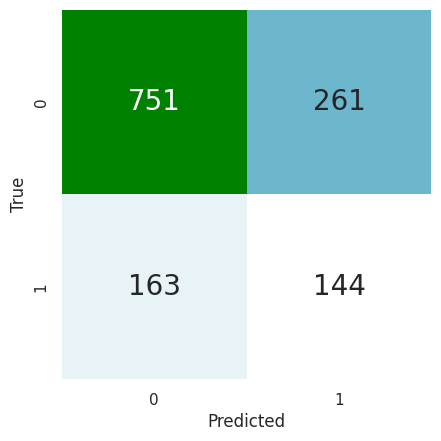

In [ ]:
# Classification report.
print('Classification report')
print(classification_report(y_train, y_train_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_train, y_train_pred, clf=model_QDA)

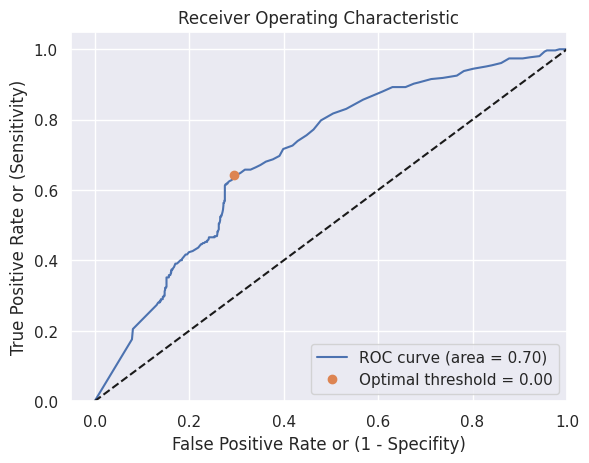

In [ ]:
# Curva ROC.
curveROC(X_train_scal, y_train, model_QDA)

####Evaluación de los resultados del test

In [ ]:
# Accuracy y error de test.
y_test_pred = model_QDA.predict(X_test_scal)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_err = 1-test_accuracy

print("Accuracy: {} \nTest error: {}".format(test_accuracy, test_err))

Accuracy: 0.6909090909090909 
Test error: 0.3090909090909091


Classification report
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       253
           1       0.36      0.40      0.38        77

    accuracy                           0.69       330
   macro avg       0.58      0.59      0.59       330
weighted avg       0.70      0.69      0.70       330

 
Matriz de confusión


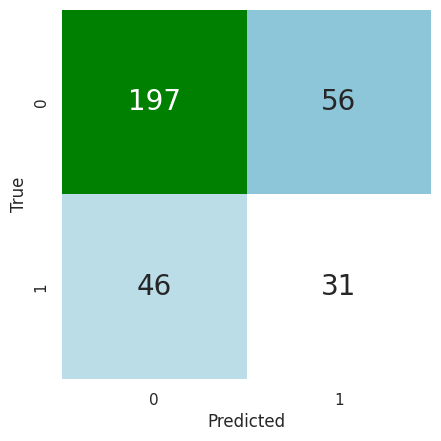

In [ ]:
# Classification report.
print('Classification report')
print(classification_report(y_test, y_test_pred))
print(' ')

# Matriz de confusión.
print('Matriz de confusión')
plot_cm(y_test, y_test_pred, clf=model_QDA)

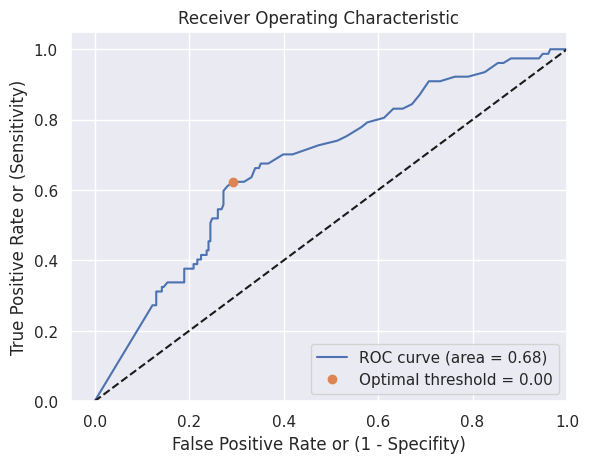

In [ ]:
# Curva ROC.
curveROC(X_test_scal, y_test, model)

### Validación cruzada

Iteración 1
Precision promedio =  0.4603174603174603
Accuracy promedio =  0.7515151515151515
Sensibility promedio =  0.37662337662337664
Specificity promedio =  0.8656126482213439
Iteración 2
Precision promedio =  0.4219395520765383
Accuracy promedio =  0.7333333333333334
Sensibility promedio =  0.37012987012987014
Specificity promedio =  0.8438735177865613
Iteración 3
Precision promedio =  0.4185479366784765
Accuracy promedio =  0.7323232323232324
Sensibility promedio =  0.367965367965368
Specificity promedio =  0.8432147562582345
Iteración 4
Precision promedio =  0.39256263790211576
Accuracy promedio =  0.7159090909090909
Sensibility promedio =  0.3668831168831169
Specificity promedio =  0.8221343873517787
Iteración 5
Precision promedio =  0.3950627685495407
Accuracy promedio =  0.7174081237911025
Sensibility promedio =  0.377717019822283
Specificity promedio =  0.8205533596837945


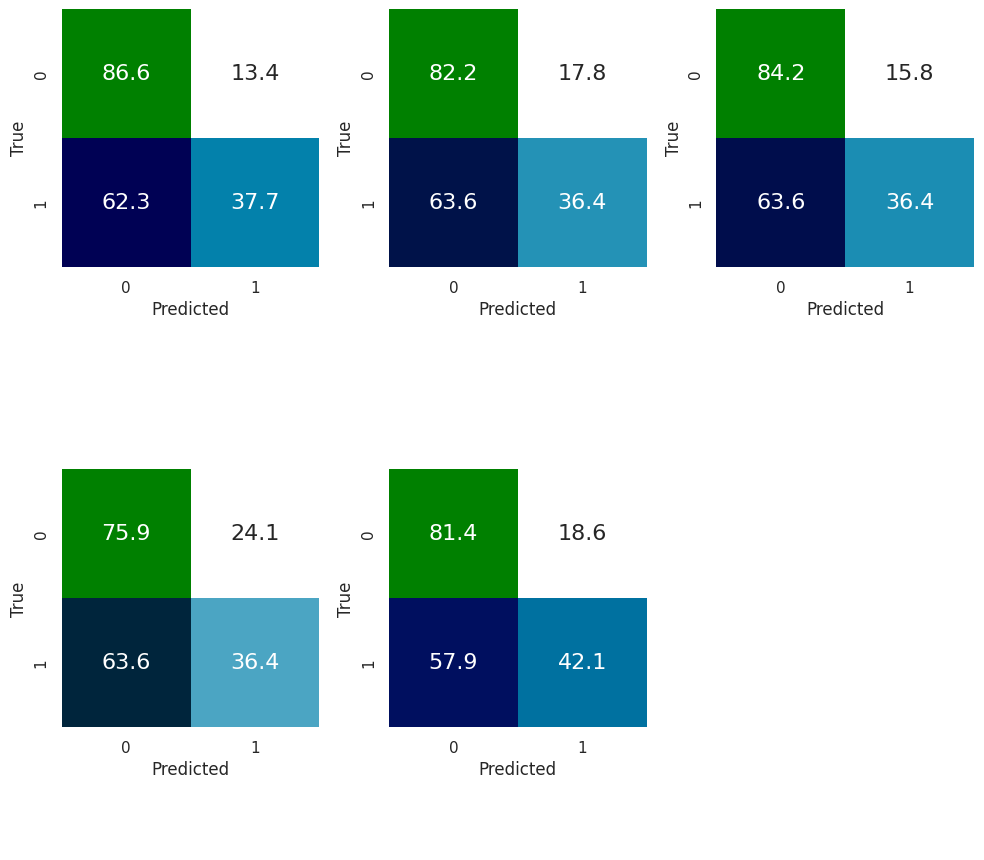

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # instancia al objeto cross validator con 5 folds

# Definición de las listas para almacenar las medidas de rendimiento
pre = []
acc = []
sen = []
spe = []

iter = 0
rocs = []

fig, ax = plt.subplots(2,3,figsize = (10,10))
k = 0
    
for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train_scaled, y_train) 
    y_pred_test = model.predict(X_test_scaled)
    
    pre.append(precision_score(y_test,y_pred_test)) 
    acc.append(accuracy_score(y_test,y_pred_test))
    sen.append(recall_score(y_test,y_pred_test))
    spe.append(recall_score(y_test,y_pred_test, pos_label=0))
    
    iter = iter + 1
    print('Iteración', iter)
    print("Precision promedio = ", np.mean(pre))
    print("Accuracy promedio = ", np.mean(acc))
    print("Sensibility promedio = ", np.mean(sen))
    print("Specificity promedio = ", np.mean(spe))
    
    # Matriz de confusion especificando los ejes (aplanados)
    plotCM(y_test,y_pred_test,normalize=True, ax = ax.flatten()[k])
    k += 1
    
    ax[1,2].axis('off')
    
    # set the spacing between subplots
    fig.tight_layout()
    
    plt.show
  
    #Las curvas ROC de cada iteración    
    y_prob = model.predict_proba(X_test)

    roc = ru.compute_roc(X=y_prob[:,1], y=y_test, pos_label=True)
    rocs.append(roc)

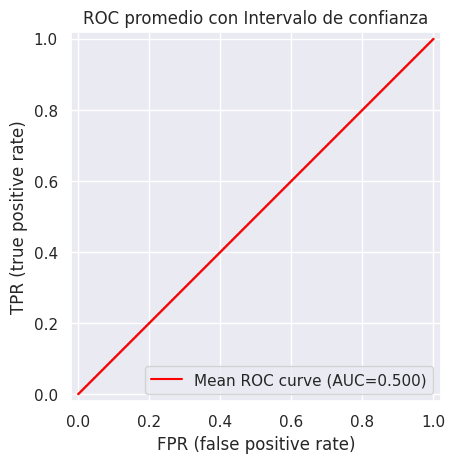

In [ ]:
# El promedio, el intervalo de tolerancia (TI) y el intervalo de confianza (IC) de las curvas ROC de cada iteración
ru.plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("ROC promedio con Intervalo de confianza");

### Discusión de resultados
Primeramente, se vuelve a apreciar, como en todos los modelos, que el "accuracy" adquiere un valor aproximado al 70%. 

Si se analiza el "Classification Report" de la validación cruzada, vemos como tanto la precisión como la sensibilidad oscilan el 40%, valores bastante más aceptable que en cualquiera de las anteriores combinaciones, dando asimismo una "F1-Score" del 40%. 

Finalmente, si se observa la curva ROC tanto para el entrenamiento como para el testeo el AUC se aproxima a 70%, el mejor de los valores obtenidos.

En conclusión, puede que el modelo 4, conformado por AGE, ZSN_A, OTEK_LANC, endocr_01 y zab_leg_01 no sea del todo óptimo para predecir la variable de salida mediante el clasificador QDA, pero, se trata de uno considerablemente robusto en comparación con las 3 combinaciones analizadas previamente.